In [1]:
import os
import random
from pathlib import Path
from typing import Union

import h5py
import numpy as np
import torchvision
from torchvision.transforms import RandomEqualize

from datasets import KCoordDataset, seed_worker
from data_utils import *
from fastmri.data.subsample import EquiSpacedMaskFunc, RandomMaskFunc
from fastmri.data.transforms import tensor_to_complex_np, to_tensor
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import config

import numpy as np
import torch
from torch import nn

type = 'trial_tb'
# path_out =  f'/scratch_net/ken/mcrespo/proj_marina/logs/{type}'
file = '/itet-stor/mcrespo/bmicdatasets-originals/Originals/fastMRI/brain/multicoil_train/file_brain_AXT1POST_203_6000861.h5'
n_volumes= 1
n_slices = 8
with_mask= False
acceleration = 4
center_frac = 0.15

with h5py.File(file, "r") as hf:
    ground_truth = hf["reconstruction_rss"][()][: n_slices]
    volume_kspace = to_tensor(preprocess_kspace(hf["kspace"][()]))[:n_slices]


In [4]:
vol_id = 0
##################################################
# Mask creation
##################################################
mask_func = RandomMaskFunc(
    center_fractions=[center_frac], accelerations=[acceleration]
)
shape = (1,) * len(volume_kspace.shape[:-3]) + tuple(
    volume_kspace.shape[-3:]
)
mask, _ = mask_func(
    shape, None, vol_id
)  # use the volume index as random seed.

mask, left_idx, right_idx = remove_center(mask)
# _, left_idx, right_idx = remove_center(mask)  # NOTE: Uncomment to include the center region in the training data. Note that 'left_idx' and 'right_idx' are still needed.

##################################################
# Computing the indices
##################################################
n_slices, n_coils, height, width = volume_kspace.shape[:-1]
if with_mask:
    kx_ids = torch.where(mask.squeeze())[0]
else:
    kx_ids = torch.arange(width)
    # kx_ids = torch.from_numpy(np.setdiff1d(np.arange(width), np.arange(left_idx, right_idx))) # NOTE: Uncomment to include all the datapoints (fully-sampled volume), with the exception of the center region.
ky_ids = torch.arange(height)
kz_ids = torch.arange(n_slices)
coil_ids = torch.arange(n_coils)

kspace_ids_grid = torch.meshgrid(kx_ids, ky_ids, kz_ids, coil_ids, indexing="ij")
kspace_ids = torch.stack(kspace_ids_grid, dim=-1).reshape(-1, len(kspace_ids_grid))

##################################################
# Computing the inputs
##################################################
# Convert indices into normalized coordinates in [-1, 1].
kspace_coords = torch.zeros((kspace_ids.shape[0], 4), dtype=torch.float)
kspace_coords[:, 0] = (2 * kspace_ids[:, 0]) / (width - 1) - 1
kspace_coords[:, 1] = (2 * kspace_ids[:, 1]) / (height - 1) - 1
kspace_coords[:, 2] = (2 * kspace_ids[:, 2]) / (n_slices - 1) - 1
kspace_coords[:, 3] = (2 * kspace_ids[:, 3]) / (n_coils - 1) - 1




(-0.5, 319.5, 319.5, -0.5)

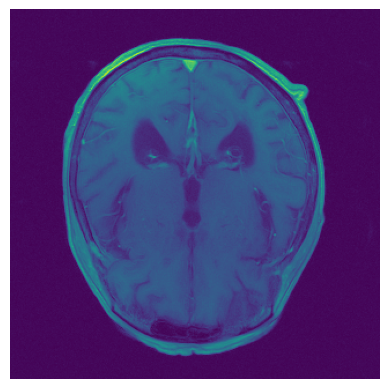

In [57]:
modulus = np.abs(tensor_to_complex_np(volume_kspace))
argument = np.angle(tensor_to_complex_np(volume_kspace))


re = torch.tensor(modulus) * torch.cos(torch.tensor(argument))
im = torch.tensor(modulus) * torch.sin(torch.tensor(argument))
volume_kspace_rebuilt = torch.complex(re, im)

img = rss(inverse_fft2_shift(volume_kspace_rebuilt))


plt.figure
# plt.hist(eq_modulus.flatten(),  log=True, bins=100)
plt.imshow(img[0,...])
plt.axis('off')

In [129]:
def normalize_hist (data):
    data_normalized = (data - np.min(data)) / (np.max(data) -  np.min(data))
    return data_normalized

def rescale_hist (data, min, max):
    data_rescaled = data * (max - min) + min
    return data_rescaled

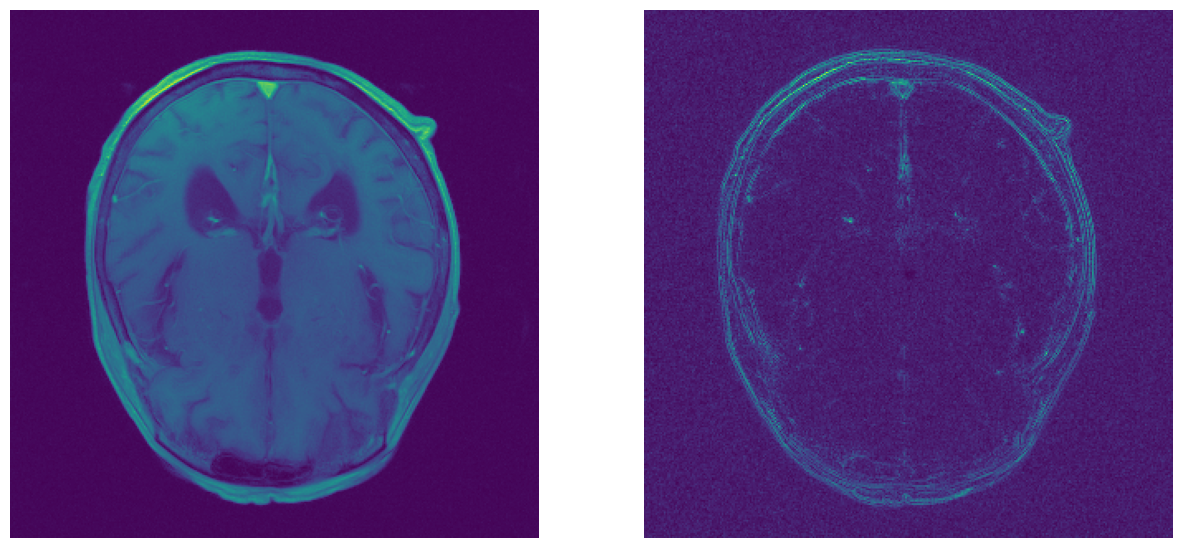

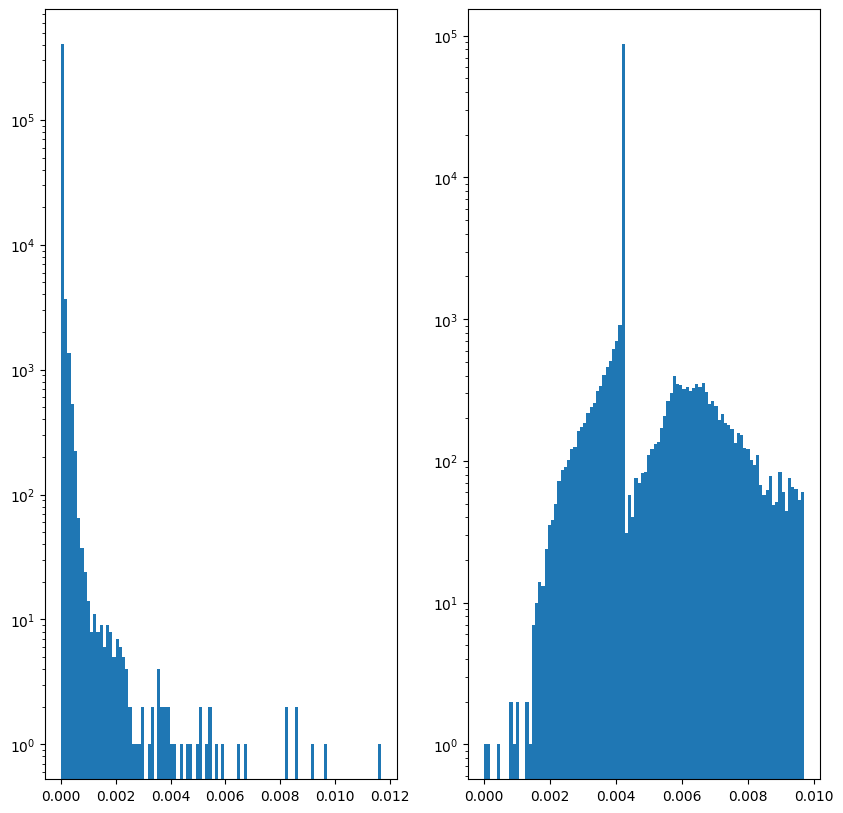

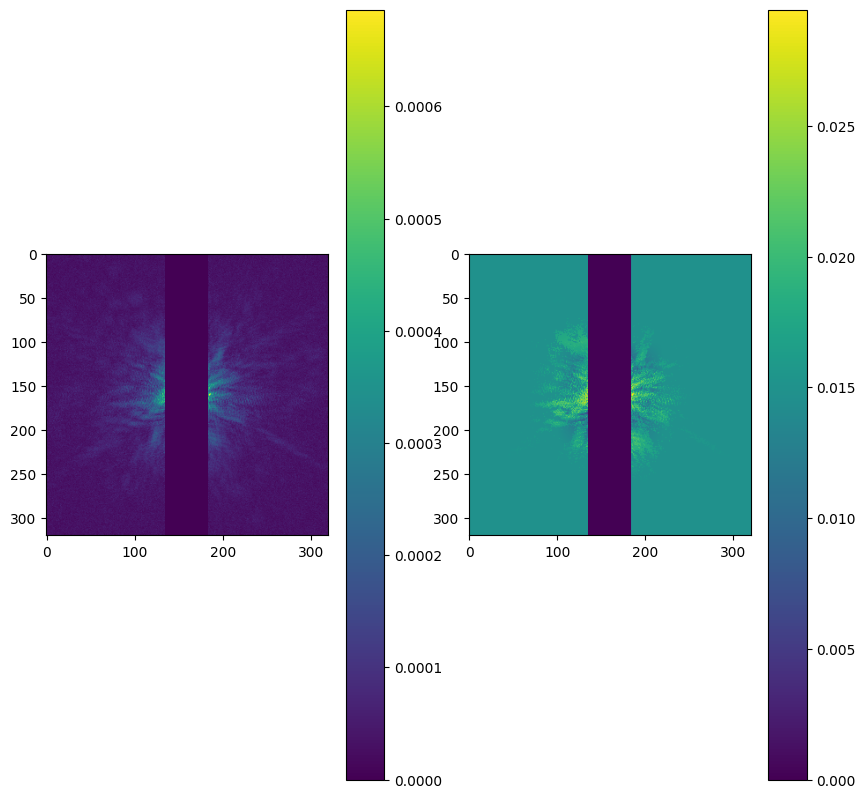

In [181]:
from skimage import exposure
import numpy
equa_value = 0.5
kvolume = torch.zeros(volume_kspace.shape, dtype=torch.double)
kvolume[kspace_ids[:,2], kspace_ids[:,3], kspace_ids[:,1], kspace_ids[:,0]] = volume_kspace[kspace_ids[:,2], kspace_ids[:,3], kspace_ids[:,1], kspace_ids[:,0]]
volume_k = tensor_to_complex_np(volume_kspace)

img = rss(inverse_fft2_shift(volume_k))

## ALL ARE TENSORS
modulus = np.abs(volume_k)
argument = np.angle(volume_k)

## CREATE THE TENSORS THAT CONTAIN EQUALIZED VERSIONS 
eq_modulus = np.zeros(modulus.shape, dtype=np.double)
eq_argument = np.zeros(argument.shape, dtype=np.double)

for coil in range(volume_k.shape[1]):
    # Normalize
    eq_modulus[0,coil,...] = normalize_hist(modulus[0,coil,...])
    eq_argument[0,coil,...] = normalize_hist(argument[0,coil,...])
    
    eq_modulus[0,coil,...] = exposure.equalize_adapthist(eq_modulus[0,coil,...],  clip_limit=equa_value)
    eq_argument[0,coil,...] = exposure.equalize_adapthist(eq_argument[0,coil,...],  clip_limit=equa_value)

    eq_modulus[0,coil,...] = rescale_hist(eq_modulus[0,coil,...], np.min(modulus[0,coil,...]), np.max(modulus[0,coil,...]))
    eq_argument[0,coil,...] = rescale_hist(eq_argument[0,coil,...], np.min(argument[0,coil,...]), np.max(argument[0,coil,...]))

eq_re = torch.tensor(eq_modulus) * torch.cos(torch.tensor(eq_argument))
eq_im = torch.tensor(eq_modulus) * torch.sin(torch.tensor(eq_argument))
eq_volume_kspace_rebuilt = torch.complex(eq_re, eq_im)
eq_img = rss(inverse_fft2_shift(eq_volume_kspace_rebuilt))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
# plt.hist(modulus[0,...].flatten(),  log=True, bins=100)
plt.imshow(img[0,...])
plt.axis('off')

plt.subplot(1,2,2)
# plt.hist(eq_modulus.flatten(),  log=True, bins=100)
plt.imshow(eq_img[0,...])
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.hist(modulus[0,...].flatten(),  log=True, bins=100)
plt.subplot(1,2,2)
plt.hist(np.abs(eq_volume_kspace_rebuilt[0,0,...]).flatten(),  log=True, bins=100)
plt.show()

plot_eq_modulus = np.sqrt(eq_modulus.sum(1)**2)
plot_modulus = np.sqrt(modulus.sum(1)**2)
plot_eq_modulus[...,left_idx:right_idx] = 0
plot_modulus[...,left_idx:right_idx] = 0

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(plot_modulus[0,...])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(plot_eq_modulus[0,...])
plt.colorbar()

In [3]:
from torch.utils.tensorboard import SummaryWriter # To print to tensorboard
from datetime import datetime
from config.config_utils import *
import yaml

timestamp = datetime.now().strftime("%m-%d_%Hh%Mm")
writer = SummaryWriter(f'{path_out} / {timestamp} ')
path_config = '/scratch_net/ken/mcrespo/proj_marina/single_vol/config/config.yaml'

config = load_config(path_config)
hparam_info = config["hparam_info"]
hparam_info["n_layer"] = config["model"]["params"]["n_layers"]
print(hparam_info)

NameError: name 'path_out' is not defined

In [12]:
import torch
x_o = torch.rand(20000,4)
L = 10

L_mult = torch.pow(2, torch.arange(L)) * torch.pi
# self.register_buffer("L_mult", L_mult)
fourier_dim = L * 2 * x_o.shape[1] + 4

x = x_o.unsqueeze(-1) * L_mult
x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
x = x.view(x.size(0), -1)
x = torch.cat([x, x_o], dim=-1)

Model Architecture
 - Layers are composed of sinusoidal activation functions
 - Network is a concatenated set of 8 sinusoidal layers, hidden dimension 512
 - Fourier encoding

In [3]:
from torch import nn

class SineLayer(nn.Module):
    """Linear layer with sine activation. Adapted from Siren repo"""

    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features

        self.linear = nn.Linear(in_features, out_features, bias=bias)
        # self.linear = nn.utils.weight_norm(nn.Linear(in_features, out_features, bias=bias))
        # self.layer_norm = nn.LayerNorm(out_features)
        # self.batch_norm = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self): # initialization function to initialize the weights in the first layer and later layers with normalized criterion
        with torch.no_grad():
            if self.is_first:
                # self.linear.weight.uniform_ - modifies the current values of the weights and they are set to a normal distribution (-1/n, 1/n)
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else: # The rest of layers are initialized with the following random values in the uniform distribution U()
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_features) / self.omega_0,
                    np.sqrt(6 / self.in_features) / self.omega_0,
                )

    def forward(self, x):
        # NOTE: Uncomment when using batch (or layer) normalization.
        # x = self.linear(x)
        # x = self.layer_norm(x)
        # x = self.batch_norm(x)
        # return torch.sin(self.omega_0 * x)

        return torch.sin(self.omega_0 * self.linear(x))
        
                
class Siren(nn.Module):
    def __init__(self,      
            c: int=4 , 
            L: int=10, 
            hidden_dim: int=512, 
            n_layers: int=8, 
            out_dim: int=2, 
            omega_0: int=30,
            outermost_linear=False,
            ) -> None:
        
        super().__init__()
        
        # self.sine_layers = nn.ModuleList()
        self.L = L
        self.c = c
        fourier_dim = self.L*2*self.c
        
        self.sine_layers = nn.ModuleList()
        self.sine_layers.append(SineLayer(fourier_dim, hidden_dim, is_first=True, omega_0=omega_0))

        for i in range(n_layers-1):
            self.sine_layers.append(
                SineLayer(hidden_dim, hidden_dim, is_first=False, omega_0=omega_0)
            )
        
        # Regarding the last layer
        if outermost_linear:
            self.final_layer = nn.Linear(hidden_dim, out_dim)
            # For initialization purposes, don't keep track of the weights when you initialize them:
            with torch.no_grad():
                self.final_layer.weight.uniform_(-np.sqrt(6 / hidden_dim) / omega_0, np.sqrt(6 / hidden_dim) / omega_0)
            
        else:
            self.final_layer = SineLayer(hidden_dim, out_dim, is_first=False, omega_0=omega_0)
            
        self.sine_layers.append(self.final_layer)
        
        # self.sine_layers = nn.Sequential(self.sine_layers)
        # self.sine_layers = nn.ModuleList(self.sine_layers)
        # self.output_layer = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, coords):
        encoder = Fourier_Enc(self.c, self.L)
        x = encoder(coords)
        for layer in self.sine_layers:
            x = layer(x)
        return x



Train the model 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming the Fourier_Enc and Siren classes are defined above this code

# Hyperparameters
len_enc = 10
initial_beta = 1
learning_rate = 0.001
num_epochs = 500
batch_size = 1_000
n_checkpoint = 100

# Initialize the model, dataset, and dataloader
fourier_encoder = Fourier_Enc(c=4,L=len_enc, initial_beta=initial_beta)
model = Siren(outermost_linear=True)
print(model)
# Move model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fourier_encoder.to(device)
model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(list(fourier_encoder.parameters()) + list(model.parameters()), lr=learning_rate)
loss_fn = nn.MSELoss()  # Example loss function; modify as needed

# Assuming you have a dataset class KCoordDataset defined and imported
dataset = KCoordDataset(path_to_data=file, n_volumes=1, n_slices=3)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    avg_loss = 0.0
    n_obs = 0
    count = 0
    for inputs, targets in dataloader:
        # Move inputs and targets to the specified device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad(set_to_none=True)

        # Pass encoded inputs through the Siren model
        outputs = model(inputs)

        # Calculate the loss
        batch_loss = loss_fn(outputs, targets)

        # Backward pass and optimization
        batch_loss.backward()
        optimizer.step()

        # Update average loss and number of observations
        avg_loss += batch_loss.item() * len(inputs)
        n_obs += len(inputs)
            
        count += 1

    # Calculate average loss for the epoch
    avg_loss /= n_obs
    if epoch % n_checkpoint == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save the model if needed
torch.save(model.state_dict(), 'siren_model.pth')



Siren(
  (sine_layers): ModuleList(
    (0): SineLayer(
      (linear): Linear(in_features=80, out_features=512, bias=True)
    )
    (1-7): 7 x SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (8): Linear(in_features=512, out_features=2, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=2, bias=True)
)


/scratch_net/ken/mcrespo/conda_envs/pytcu11/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789560443/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4000x20 and 80x512)

In [160]:
L_mult = torch.pow(2, torch.arange(10)) * np.pi
x = kspace_coords.unsqueeze(-1) * L_mult
x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
x = x.view(x.size(0), -1)
print(x[0,...].shape)

torch.Size([80])


In [164]:
(2 * np.pi * coor.unsqueeze(-1) * B_scaled).shape

torch.Size([4, 10])

In [100]:
dataset = KCoordDataset(file,)
# Ground truth (used to compute the evaluation metrics).
dataloader = DataLoader(dataset, batch_size=120, num_workers=3, shuffle=True)
file = dataloader.dataset.metadata[0]["file"]

with h5py.File(file, "r") as hf:
    ground_truth = hf["reconstruction_rss"][()][
        : n_slices]
    
# plt.subplot(1, 2, 1)
# plt.imshow(ground_truth[0,...])
# plt.axis('off')

avg_loss = 0.0
n_obs = 0

class Trainer():
    def __init__(
        self, device, model, loss_fn, optimizer, scheduler, config,
    ):
        self.model = model
        
        if hasattr(loss_fn, "to"):
            self.loss_fn = loss_fn.to(self.device)
        else:
            self.loss_fn = loss_fn
            
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.model.train()
    
    def train(self):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad(set_to_none=True)

            outputs = self.model(inputs)
            # Can be thought as a moving average (with "stride" `batch_size`) of the loss.
            batch_loss = self.loss_fn(outputs, targets)
            # NOTE: Uncomment for some of the loss functions (e.g. 'MSEDistLoss').
            # batch_loss = self.loss_fn(outputs, targets, inputs)

            batch_loss.backward()
            self.optimizer.step()

            avg_loss += batch_loss.item() * len(inputs)
            n_obs += len(inputs)

        self.scheduler.step()
        avg_loss = avg_loss / n_obs
        return avg_loss

n_epochs = 100
empirical_risk = 0
for epoch_idx in range(n_epochs):

    print(f"EPOCH {epoch_idx}    avg loss: {empirical_risk}\n")
